In [2]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [207]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float32))
        # self.mu = nn.Parameter(torch.tensor([0.0] * dimensions, dtype=torch.float32))
        # self.M = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float32))
        self.L = torch.eye(dimensions, dtype=torch.float32)

    def forward(self, x):
        cov = self.L @ self.L.T
        cov_inv = torch.linalg.inv(cov)
        diff = x - self.mu
        return -0.5 * (diff.T @ cov_inv @ diff)

In [137]:
class Gaussian_1d(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        # self.mu = nn.Parameter(torch.tensor([0.0] * dimensions, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(1, dtype=torch.float32))
        # self.L = torch.eye(dimensions, dtype=torch.float32)

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2/self.sigma**2)

In [208]:
def compute_psi(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(
        nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
    return psi

In [209]:
def gaussian_psi(x, mu=torch.tensor([0.0, 0.0]), cov=torch.eye(2, dtype=torch.float32)):
    return -torch.linalg.inv(cov) @ (x - mu)

In [210]:
def gaussian_J(x_t, mu=torch.tensor([0.0, 0.0]), cov=torch.eye(2, dtype=torch.float32)):
    cov_inv = torch.linalg.inv(cov) 
    diff = x_t - mu
    T = len(x_t)
    trace_term = -torch.trace(cov_inv)
    quadratic_term = 0.5 * (diff.T @ cov_inv @ diff)
    return trace_term + quadratic_term

In [ ]:
def J(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0
    psi, real_psi = [], []

    for t in range(T):
        x = x_t[t]
        psi_x_t = compute_psi(x, model)
        
        psi.append(psi_x_t.detach().numpy())
        real_psi.append(gaussian_psi(x, model.mu.detach(), model.L.detach() @ model.L.detach()).detach().numpy())
        
        divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        norm_squared = (psi_x_t ** 2).sum()

        real_sum += gaussian_J(x, model.mu.detach(), model.L.detach())
        total_sum += 0.5 * norm_squared + divergence

    print("Real sum:", real_sum)
    print("Calculated sum:", total_sum)
   
    time_steps = np.arange(T)

    psi_np = np.array(psi)
    real_psi_np = np.array(real_psi)

    num_components = psi_np.shape[1]
    plt.figure(figsize=(10, 6))
    for i in range(num_components):
        plt.plot(
            time_steps, real_psi_np[:, i], linestyle="--", label=f"Real ψ (component {i+1})"
        )
        plt.plot(
            time_steps, psi_np[:, i], linestyle="-", label=f"Calculated ψ (component {i+1})"
        )

    plt.title("Real and Calculated ψ Components over Time")
    plt.xlabel("Time Steps (T)")
    plt.ylabel("ψ")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return total_sum / T

In [134]:
def optimize_theta_gaussian_1d(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_L=1e-4, l2_reg=1e-4, clip_value=1.0,
    ):
    model = Gaussian_1d(dim)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.sigma], "lr": learning_rate_L},
        ]
    )
    losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float32)
        loss = J(x_t_tensor, model)

        # l2_loss = sum((param ** 2).sum() for param in model.parameters())
        # loss += l2_reg * l2_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        print(f"Epoch {epoch}, mu: {model.mu}")
        print(f"Epoch {epoch}, sigma: {model.sigma}")
        optimizer.step()

        losses.append(loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.sigma.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_mus, estimated_covs

In [141]:
def optimize_theta_gaussian(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_L=1e-4, l2_reg=1e-4, clip_value=1.0,
    ):
    model = Gaussian(dim)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.L], "lr": learning_rate_L},
        ]
    )
    losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float32)
        loss = J(x_t_tensor, model)

        # l2_loss = sum((param ** 2).sum() for param in model.parameters())
        # loss += l2_reg * l2_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        print(f"Epoch {epoch}, mu: {model.mu}")
        print(f"Epoch {epoch}, cov: {model.L}")
        optimizer.step()

        losses.append(loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append((model.L).detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_mus, estimated_covs

In [96]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [204]:
n = 1000
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
x_t_all = generate_multivariate_gaussian_data(mu, cov, n)
dim = x_t_all.shape[1]

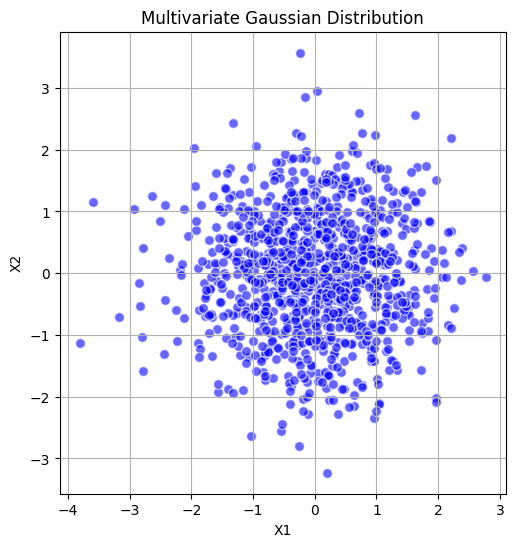

In [205]:
plt.figure(figsize=(8, 6))
plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Real sum: tensor(270.4762, grad_fn=<AddBackward0>)
Calculated sum: tensor(1538.1975, grad_fn=<AddBackward0>)


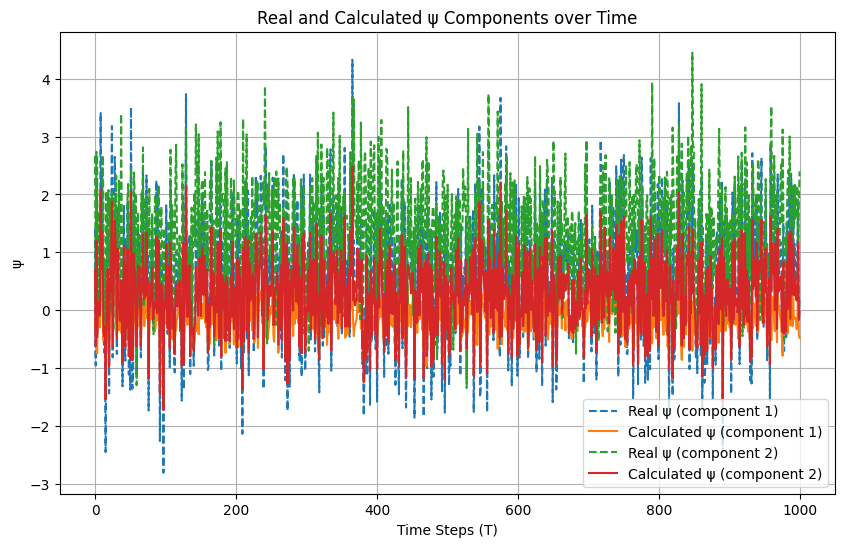

Epoch 0, mu: Parameter containing:
tensor([ 1.1847, -0.8008], requires_grad=True)
Epoch 0, cov: Parameter containing:
tensor([[-0.2265, -1.0626],
        [ 0.6741, -0.6309]], requires_grad=True)
Epoch 0/100, Loss: 1.5381975173950195
Real sum: tensor(271.0979, grad_fn=<AddBackward0>)
Calculated sum: tensor(1536.8507, grad_fn=<AddBackward0>)


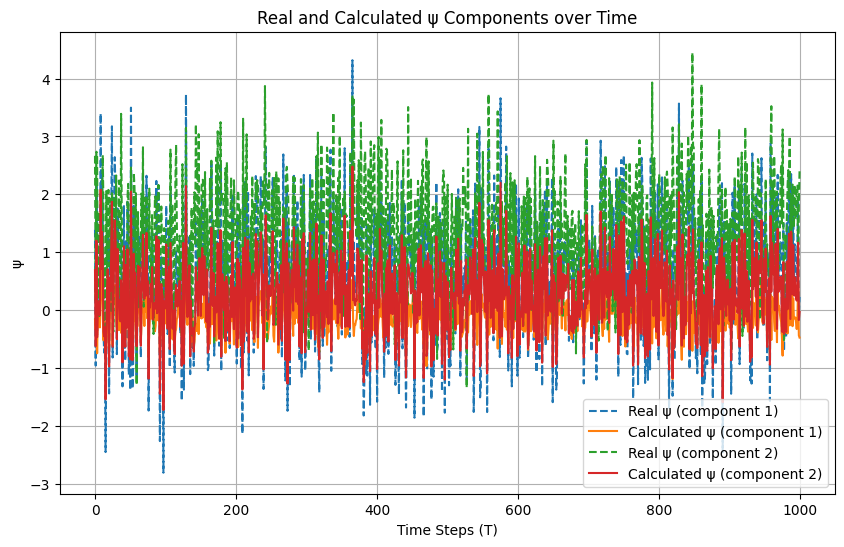

Epoch 1, mu: Parameter containing:
tensor([ 1.1897, -0.7958], requires_grad=True)
Epoch 1, cov: Parameter containing:
tensor([[-0.2264, -1.0625],
        [ 0.6742, -0.6308]], requires_grad=True)
Epoch 1/100, Loss: 1.5368506908416748
Real sum: tensor(271.8037, grad_fn=<AddBackward0>)
Calculated sum: tensor(1535.2594, grad_fn=<AddBackward0>)


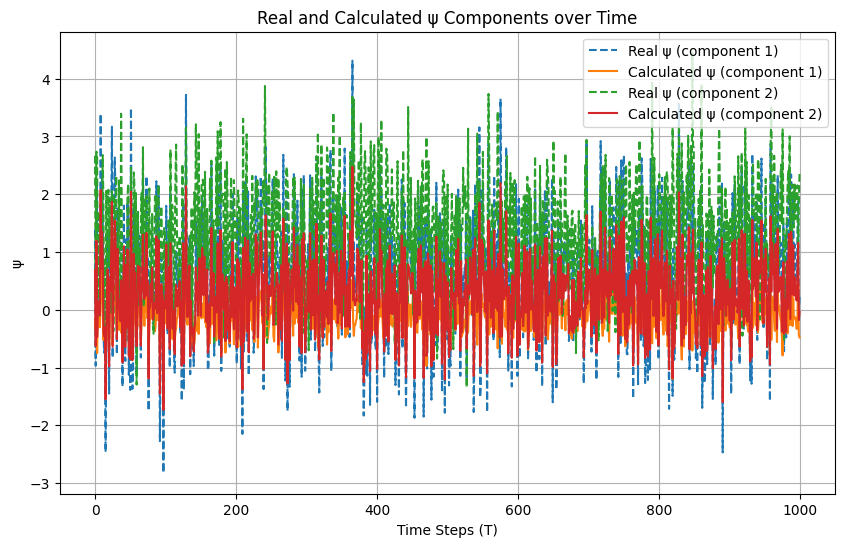

Epoch 2, mu: Parameter containing:
tensor([ 1.1957, -0.7898], requires_grad=True)
Epoch 2, cov: Parameter containing:
tensor([[-0.2263, -1.0624],
        [ 0.6744, -0.6307]], requires_grad=True)
Epoch 2/100, Loss: 1.5352593660354614


KeyboardInterrupt: 

In [206]:
epochs = 100
model, losses, estimated_mus, estimated_covs = optimize_theta_gaussian(x_t_all, dim, num_epochs=epochs, learning_rate_mu=5e-3)

In [126]:
x = torch.randn(10000)

In [138]:
epochs = 100
model, losses, estimated_mus, estimated_covs = optimize_theta_gaussian_1d(x, 1, num_epochs=epochs, learning_rate_mu=5e-3)

C:\Users\79217\AppData\Local\Temp\ipykernel_20036\63402021.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_tensor = torch.tensor(x_t_all, dtype=torch.float32)


Epoch 0, mu: Parameter containing:
tensor(0., requires_grad=True)
Epoch 0, sigma: Parameter containing:
tensor(1., requires_grad=True)
Epoch 0/100, Loss: -0.5067340731620789
Epoch 1, mu: Parameter containing:
tensor(-0.0050, requires_grad=True)
Epoch 1, sigma: Parameter containing:
tensor(0.9999, requires_grad=True)
Epoch 1/100, Loss: -0.5067475438117981
Epoch 2, mu: Parameter containing:
tensor(-0.0050, requires_grad=True)
Epoch 2, sigma: Parameter containing:
tensor(0.9998, requires_grad=True)
Epoch 2/100, Loss: -0.5067530870437622
Epoch 3, mu: Parameter containing:
tensor(-0.0025, requires_grad=True)
Epoch 3, sigma: Parameter containing:
tensor(0.9996, requires_grad=True)
Epoch 3/100, Loss: -0.5067532658576965
Epoch 4, mu: Parameter containing:
tensor(-0.0025, requires_grad=True)
Epoch 4, sigma: Parameter containing:
tensor(0.9995, requires_grad=True)
Epoch 4/100, Loss: -0.5067567229270935
Epoch 5, mu: Parameter containing:
tensor(-0.0037, requires_grad=True)
Epoch 5, sigma: Paramet

In [143]:
os.makedirs('data', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

losses_file = f"data/run_{timestamp}_losses_epoch_{epochs}.npy"
mus_file = f"data/run_{timestamp}_mus_epoch_{epochs}.npy"
covs_file = f"data/run_{timestamp}_covs_epoch_{epochs}.npy"

np.save(losses_file, losses)
np.save(mus_file, estimated_mus)
np.save(covs_file, estimated_covs)

print(f"Saved files: {losses_file}, {mus_file}, {covs_file}")

Saved files: data/run_20241121_153011_losses_epoch_100.npy, data/run_20241121_153011_mus_epoch_100.npy, data/run_20241121_153011_covs_epoch_100.npy


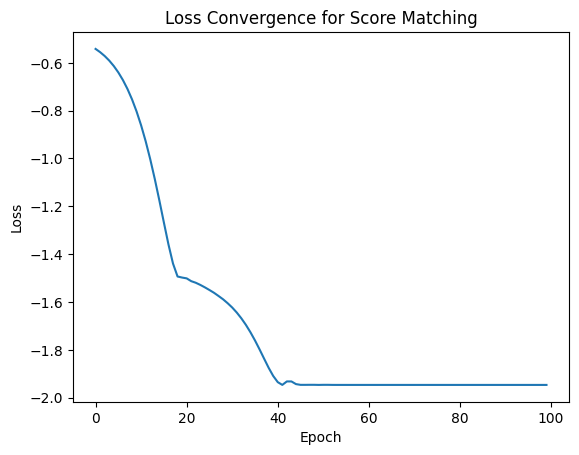

In [144]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.show()

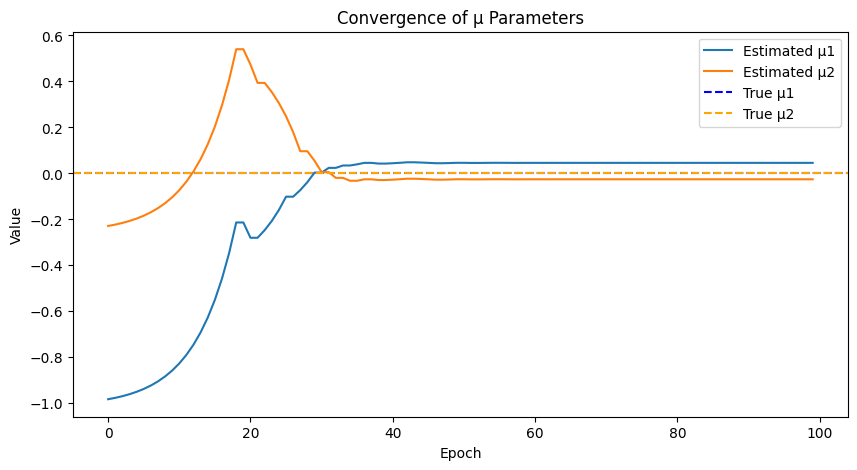

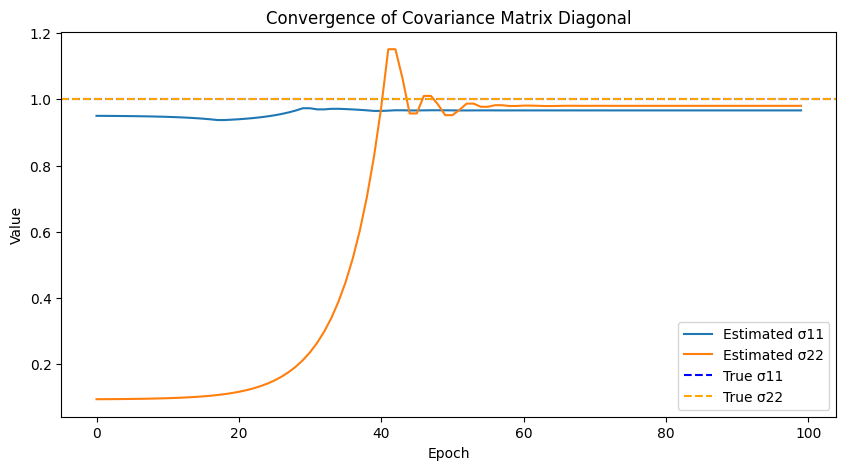

In [145]:
estimated_mus = np.array(estimated_mus)
plt.figure(figsize=(10, 5))
plt.plot(estimated_mus[:, 0], label="Estimated μ1")
plt.plot(estimated_mus[:, 1], label="Estimated μ2")
plt.axhline(mu[0], color='blue', linestyle='--', label="True μ1")
plt.axhline(mu[1], color='orange', linestyle='--', label="True μ2")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

# Plot convergence of covariance matrix diagonal (variance terms)
estimated_covs_diag = np.array([np.diag(cov) for cov in estimated_covs])
plt.figure(figsize=(10, 5))
plt.plot(estimated_covs_diag[:, 0], label="Estimated σ11")
plt.plot(estimated_covs_diag[:, 1], label="Estimated σ22")
plt.axhline(cov[0, 0], color='blue', linestyle='--', label="True σ11")
plt.axhline(cov[1, 1], color='orange', linestyle='--', label="True σ22")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of Covariance Matrix Diagonal')
plt.show()

In [148]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", torch.linalg.inv(torch.tensor(estimated_covs[-1])))
print("True Σ:\n", cov)

Final estimated μ: [ 0.04588835 -0.02560537]
True μ: [0. 0.]

Final estimated Σ:
 tensor([[ 4.1746, -6.2083],
        [-2.0816,  4.1157]])
True Σ:
 [[1. 0.]
 [0. 1.]]


In [151]:
model_mu = torch.tensor(estimated_mus[-1])
model_cov = torch.linalg.inv(torch.tensor(estimated_covs[-1]))
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

C:\Users\79217\AppData\Local\Temp\ipykernel_20036\2233108499.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.random.multivariate_normal(mean, cov, num_samples)
C:\Users\79217\AppData\Local\Temp\ipykernel_20036\2233108499.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, num_samples)


In [160]:
sum = 0
for x_t in torch.tensor(x_t_all, dtype=torch.float32):
    sum += gaussian_J(x_t, model_mu, model_cov)
sum/len(x_t_all)

tensor(-7.2904)

In [162]:
sum = 0
for x_t in torch.tensor(x_t_all, dtype=torch.float32):
    sum += gaussian_J(x_t, torch.tensor(mu, dtype=torch.float32), torch.tensor(cov, dtype=torch.float32))
sum/len(x_t_all)

tensor(-0.9992)

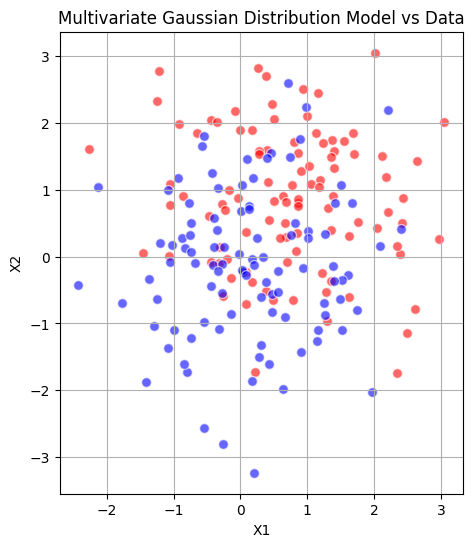

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [117]:
x = torch.tensor([-1.0856, 0.9973])

model = Gaussian(x.shape[0])
psi_x_t = compute_psi(x, model)
print("Real psi:", gaussian_psi(x))
print("Calculated psi:", psi_x_t)

divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
norm_squared = (psi_x_t ** 2).sum()
        
print("Real sum:", gaussian_J(x))
print("Calculated sum:", 0.5 * norm_squared + divergence)


Real psi: tensor([ 1.0856, -0.9973], grad_fn=<MvBackward0>)
Calculated psi: tensor([ 1.9008, -0.0191], grad_fn=<AddBackward0>)
Real sum: tensor(-0.9134, grad_fn=<AddBackward0>)
Calculated sum: tensor(-0.1933, grad_fn=<AddBackward0>)
